In [8]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
import numpy as np
import copy
import warnings
import random
import scipy
import pickle
import os
import nept
import scalebar

from loading_data import get_data
from analyze_tuning_curves import get_only_tuning_curves
from utils_maze import get_zones
from utils_maze import get_bin_centers

thisdir = os.getcwd()
pickle_filepath = os.path.join(thisdir, "cache", "pickled")
output_filepath = os.path.join(thisdir, "plots", "decoding", "sequenceless")
if not os.path.exists(output_filepath):
    os.makedirs(output_filepath)

# Set random seeds
random.seed(0)
np.random.seed(0)

In [9]:
class Session:
    """A collection of LikelihoodsAtTaskTime for each session

        Parameters
        ----------
        task_times : dict of TaskTime

    """

    def __init__(self, position, task_labels, zones):
        self.position = position
        self.task_labels = task_labels
        for task_label in task_labels:
            setattr(self, task_label, TaskTime([], [], [], zones))

    def pickle(self, save_path):
        with open(save_path, 'wb') as fileobj:
            print("Saving " + save_path)
            pickle.dump(self, fileobj)

    def n_tasktimes(self):
        return len(self.task_labels)


class TaskTime:
    """A set of decoded likelihoods for a given task time

        Parameters
        ----------
        likelihoods : np.array
            With shape (ntimebins, nxbins, nybins)
        zones : dict of Zones

        Attributes
        ----------
        likelihoods : np.array
            With shape (ntimebins, nxbins, nybins)

    """

    def __init__(self, tuning_curves, swrs, likelihoods, zones):
        self.tuning_curves = tuning_curves
        self.swrs = swrs
        self.likelihoods = likelihoods
        self.zones = zones

    def sums(self, zone_label):
        return np.nansum(self.likelihoods[:, :, self.zones[zone_label]], axis=2)

    def means(self, zone_label):
        return np.nanmean(self.likelihoods[:, :, self.zones[zone_label]], axis=2)

    def maxes(self, zone_label):
        return np.nanmax(self.likelihoods[:, :, self.zones[zone_label]], axis=2)


def get_likelihoods(info, swr_params, task_labels, n_shuffles=0, save_path=None):
    _, position, spikes, lfp, _ = get_data(info)

    zones = dict()
    zones["u"], zones["shortcut"], zones["novel"] = get_zones(info, position, subset=True)
    combined_zones = zones["u"] + zones["shortcut"] + zones["novel"]
    zones["other"] = ~combined_zones

    if n_shuffles > 0:
        n_passes = n_shuffles
    else:
        n_passes = 1

    session = Session(position, task_labels, zones)

    tuning_curves_fromdata = get_only_tuning_curves(info, position, spikes, info.task_times["phase3"])

    tc_shape = tuning_curves_fromdata.shape

    phase_for_zthresh = "pauseB"

    swrs = nept.detect_swr_hilbert(lfp,
                                   fs=info.fs,
                                   thresh=swr_params["swr_thresh"],
                                   z_thresh=info.lfp_z_thresh,
                                   merge_thresh=swr_params["merge_thresh"],
                                   min_length=swr_params["min_length"],
                                   times_for_z=nept.Epoch(info.task_times[phase_for_zthresh].start,
                                                          info.task_times[phase_for_zthresh].stop))

    swrs = nept.find_multi_in_epochs(spikes, swrs, min_involved=swr_params["min_involved"])

    rest_epochs = nept.rest_threshold(position, thresh=12., t_smooth=0.8)

    for task_label in task_labels:
        epochs_of_interest = info.task_times[task_label].intersect(rest_epochs)

        phase_swrs = epochs_of_interest.overlaps(swrs)
        phase_swrs = phase_swrs[phase_swrs.durations >= 0.05]

        phase_likelihoods = np.zeros((n_passes, phase_swrs.n_epochs, tc_shape[1], tc_shape[2]))
        phase_tuningcurves = np.zeros((n_passes, tc_shape[0], tc_shape[1], tc_shape[2]))
        for n_pass in range(n_passes):

            if n_shuffles > 0:
                tuning_curves = np.random.permutation(tuning_curves_fromdata)
            else:
                tuning_curves = tuning_curves_fromdata

            phase_tuningcurves[n_pass, ] = tuning_curves
            tuning_curves = tuning_curves.reshape(tc_shape[0], tc_shape[1] * tc_shape[2])

            if phase_swrs.n_epochs == 0:
                phase_likelihoods = np.ones((n_passes, 1, tc_shape[1], tc_shape[2])) * np.nan
            else:
                counts_data = []
                counts_time = []
                t_windows = []

                for n_timebin, (start, stop) in enumerate(zip(phase_swrs.starts,
                                                              phase_swrs.stops)):
                    t_window = stop - start  # 0.1 for running, 0.025 for swr

                    sliced_spikes = [spiketrain.time_slice(start, stop) for spiketrain in spikes]

                    these_counts = nept.bin_spikes(sliced_spikes,
                                                   start,
                                                   stop,
                                                   dt=t_window,
                                                   gaussian_std=0.0075,
                                                   normalized=False,
                                                   lastbin=True)

                    counts_data.append(these_counts.data)
                    counts_time.append(these_counts.time)
                    t_windows.append(t_window)

                counts = nept.AnalogSignal(np.vstack(counts_data), np.hstack(counts_time))
                likelihood = nept.bayesian_prob(counts,
                                                tuning_curves,
                                                binsize=t_windows,
                                                min_neurons=3,
                                                min_spikes=1)

                phase_likelihoods[n_pass] = likelihood.reshape(phase_swrs.n_epochs, tc_shape[1], tc_shape[2])

        tasktime = getattr(session, task_label)
        tasktime.likelihoods = phase_likelihoods
        tasktime.tuning_curves = phase_tuningcurves
        tasktime.swrs = phase_swrs

    if save_path is not None:
        session.pickle(save_path)

    return session


def limit_by_n_swr(session, task_labels, n_swr_thresh, zone_label="u"):
    session_copy = copy.deepcopy(session)
    
    for task_label in task_labels:
        if getattr(session_copy, task_label).swrs.n_epochs < n_swr_thresh:
            zone_shape = getattr(session_copy, task_label).zones[zone_label].shape
            getattr(session_copy, task_label).likelihoods = np.ones((1, 1, zone_shape[0], zone_shape[1])) * np.nan
    
    return session_copy

In [20]:
def plot_session(sessions, title, task_labels, zone_labels, colours, filepath=None):

    fig = plt.figure(figsize=(12, 6))
    gs1 = gridspec.GridSpec(1, 4)
    gs1.update(wspace=0.3, hspace=0.)
    
    n_session_above_thresh = {task_label: 0 for task_label in task_labels}
    for session in sessions:
        for task_label in task_labels:
            likelihoods = getattr(session, task_label).likelihoods
            if likelihoods.shape[1] > 1:
                n_session_above_thresh[task_label] += 1

    for i, zone_label in enumerate(zone_labels):
        sums = {task_label: [] for task_label in task_labels}
        n_swrs = {task_label: 0 for task_label in task_labels}
        for session in sessions:
            for task_label in task_labels:
                zone_sums = getattr(session, task_label).sums(zone_label)
                if zone_sums.size == 1:
                    sums[task_label].extend([np.nan])
                else:
                    sums[task_label].extend(zone_sums)
                    n_swrs[task_label] += getattr(session, task_label).swrs.n_epochs

        for task_label in task_labels:
            sums[task_label] = np.hstack(sums[task_label])

        means = [np.nanmean(sums[task_label])
                 if n_swrs[task_label] != 0 else 0.0
                 for task_label in task_labels]

        sems = [np.nanmean(scipy.stats.sem(sums[task_label], nan_policy="omit"))
                if n_swrs[task_label] != 0 else 0.0
                for task_label in task_labels]

        ax = plt.subplot(gs1[i])
        ax.bar(np.arange(sessions[0].n_tasktimes()),
               means, yerr=sems, color=colours[zone_label])

        ax.set_ylim([0, 1.])

        ax.set_xticks(np.arange(sessions[0].n_tasktimes()))
        ax.set_xticklabels(task_labels, rotation=90)

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')

        if i > 0:
            ax.set_yticklabels([])

        if i == 0:
            ax.set_ylabel("Proportion")

        if zone_label == "other":
            for n_tasktimes, task_label in enumerate(task_labels):
                ax.text(n_tasktimes, 0.01, str(n_swrs[task_label]), ha="center", fontsize=10)
                
#             for n_session, task_label in enumerate(task_labels):
#                 ax.text(n_session, 0.3, str(n_session_above_thresh[task_label]), ha="center", fontsize=11, color="b")

    plt.text(1., 1., "n sessions: " + str(len(sessions)), horizontalalignment='left',
             verticalalignment='top', fontsize=14)

    fig.suptitle(title, fontsize=16)

    legend_elements = [Patch(facecolor=colours[zone_label], edgecolor='k', label=zone_label)
                       for zone_label in zone_labels]

    plt.legend(handles=legend_elements, bbox_to_anchor=(1., 0.95))

    gs1.tight_layout(fig)

    if filepath is not None:
        plt.savefig(filepath)
        plt.close()
    else:
        plt.show()

In [21]:
import info.r063d2 as r063d2
import info.r063d3 as r063d3
from run import analysis_infos

# infos = [r063d2, r063d3]
infos = analysis_infos

# swr params
swr_params = dict()
swr_params["merge_thresh"] = 0.02
swr_params["min_length"] = 0.05
swr_params["swr_thresh"] = (140.0, 250.0)
swr_params["min_involved"] = 4

colours = dict()
colours["u"] = "#2b8cbe"
colours["shortcut"] = "#31a354"
colours["novel"] = "#d95f0e"
colours["other"] = "#bdbdbd"

task_labels = ["prerecord", "pauseA", "pauseB", "postrecord"]
zone_labels = ["u", "shortcut", "novel", "other"]

In [22]:
update_cache = False
dont_save_pickle = False

true_sessions = []

for info in infos:
    print(info.session_id)

    # Get true data
    true_path = os.path.join(pickle_filepath, info.session_id + "_likelihoods_true.pkl")
    
    # Remove previous pickle if update_cache
    if update_cache:
        if os.path.exists(true_path):
            os.remove(true_path)

    # Load pickle if it exists, otherwise compute and pickle
    if os.path.exists(true_path):
        print("Loading pickled true likelihoods...")
        compute_likelihoods = False
        with open(true_path, 'rb') as fileobj:
            true_session = pickle.load(fileobj)
    else:
        if dont_save_pickle:
            true_path = None
        true_session = get_likelihoods(info,
                                       swr_params,
                                       task_labels,
                                       n_shuffles=0,
                                       save_path=true_path)

    true_sessions.append(true_session)

R063d2
Loading pickled true likelihoods...
R063d3
Loading pickled true likelihoods...
R063d4
Loading pickled true likelihoods...
R063d5
Loading pickled true likelihoods...
R063d6
Loading pickled true likelihoods...
R063d7
Loading pickled true likelihoods...
R063d8
Loading pickled true likelihoods...
R066d1
Loading pickled true likelihoods...
R066d2
Loading pickled true likelihoods...
R066d3
Loading pickled true likelihoods...
R066d4
Loading pickled true likelihoods...
R066d5
Loading pickled true likelihoods...
R066d6
Loading pickled true likelihoods...
R066d7
Loading pickled true likelihoods...
R066d8
Loading pickled true likelihoods...
R067d1
Loading pickled true likelihoods...
R067d2
Loading pickled true likelihoods...
R067d3
Loading pickled true likelihoods...
R067d8
Loading pickled true likelihoods...
R068d1
Loading pickled true likelihoods...
R068d2
Loading pickled true likelihoods...
R068d3
Loading pickled true likelihoods...
R068d4
Loading pickled true likelihoods...
R068d5
Load

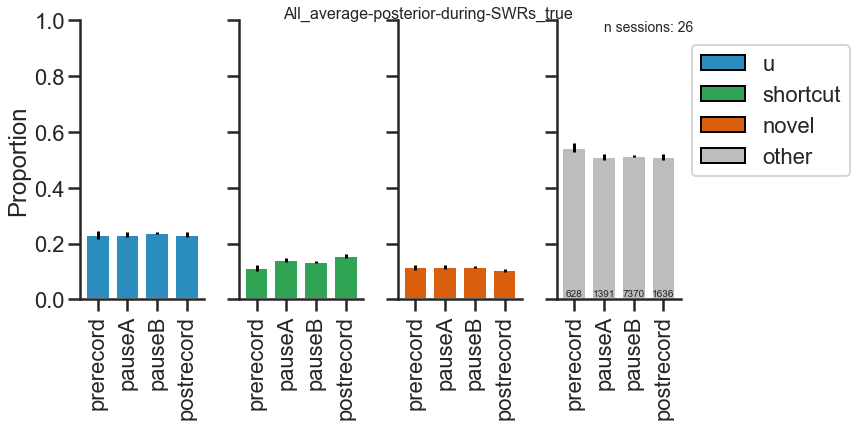

In [23]:
sessions_copy = []
for session in true_sessions:
    session_copy = limit_by_n_swr(session, task_labels, n_swr_thresh=10)
    sessions_copy.append(session_copy)

title = "All" + "_average-posterior-during-SWRs_true"
plot_session(sessions_copy, title, task_labels, zone_labels, colours)

n_swr thresh: 5


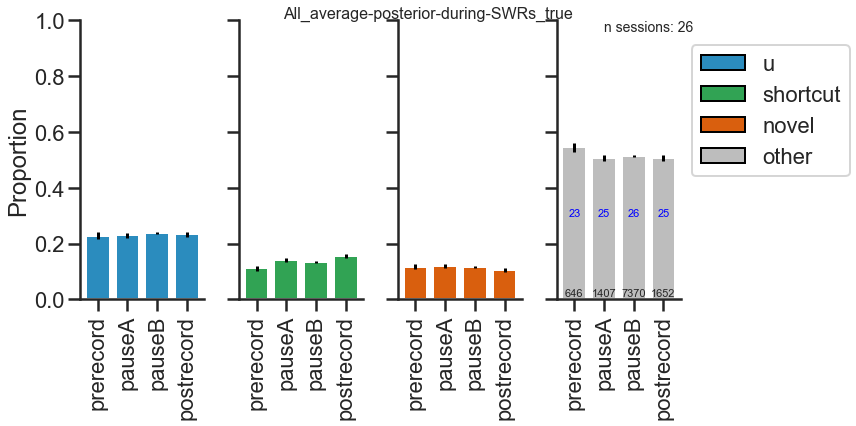

n_swr thresh: 10


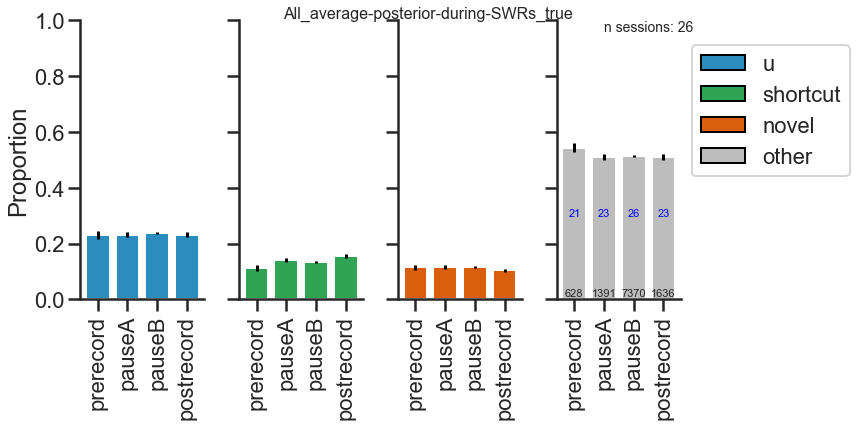

n_swr thresh: 20


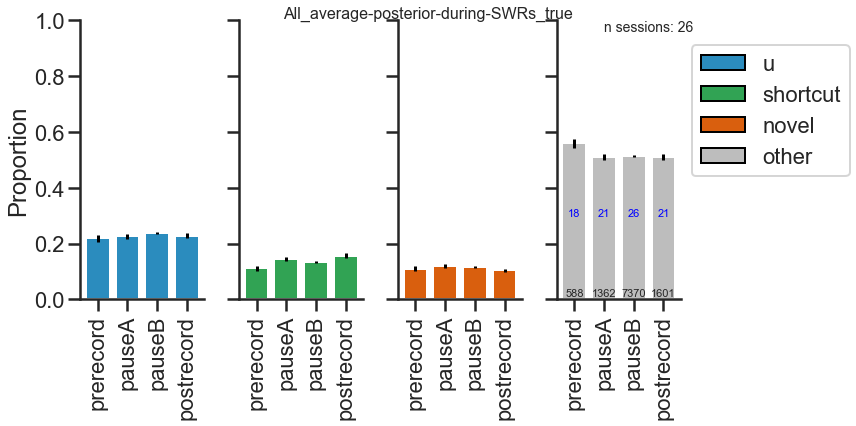

n_swr thresh: 30


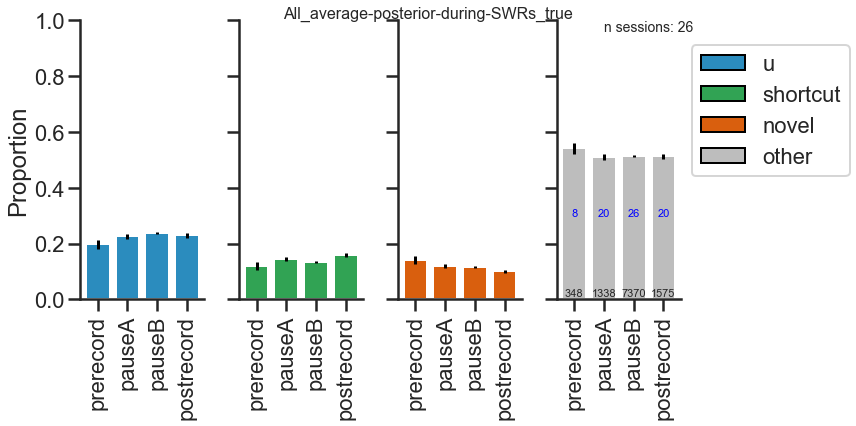

n_swr thresh: 40


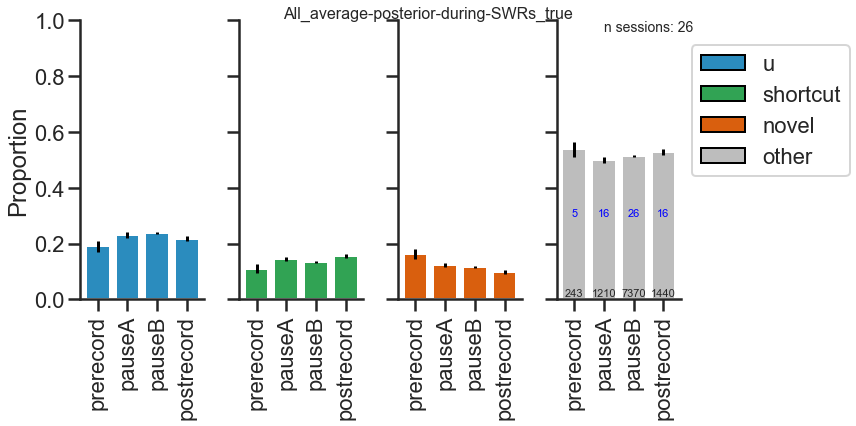

n_swr thresh: 50


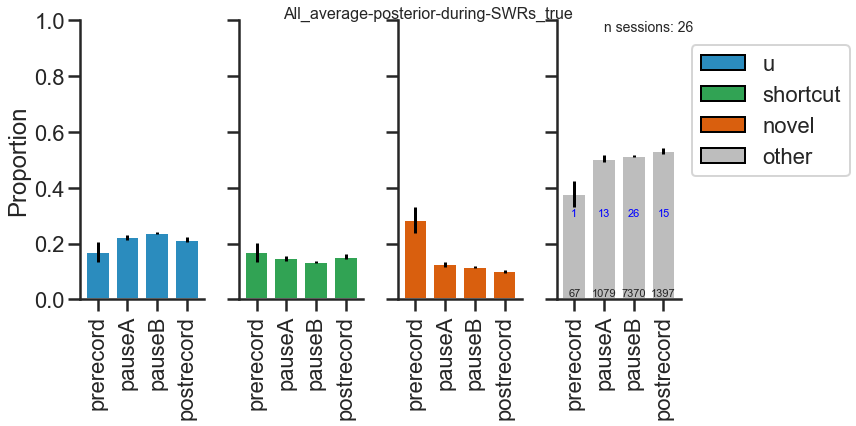

In [14]:
n_swr_threshs = [5, 10, 20, 30, 40, 50]

for n_swr_thresh in n_swr_threshs:
    print("n_swr thresh:", n_swr_thresh)
    sessions_copy = []
    for session in true_sessions:
        session_copy = limit_by_n_swr(session, task_labels, n_swr_thresh=n_swr_thresh)
        sessions_copy.append(session_copy)

    title = "All" + "_average-posterior-during-SWRs_true"
    plot_session(sessions_copy, title, task_labels, zone_labels, colours)

In [28]:
task_label = "pauseB"
zone_label = "shortcut"
true_sums = np.array(getattr(true_session, task_label).sums(zone_label))
# shuffled_sums = np.array(getattr(shuffled_session, task_label).sums(zone_label))
# percentile = scipy.stats.percentileofscore(np.sort(shuffled_sums[:, idx]), true_sums[:, idx])

In [31]:
for idx in range(true_sums.shape[1]):
    print(true_sums[:, idx][0])

0.010836031238296105
0.0033000659965304303
0.07938845289753066
0.09650596255798685
0.001916197174376166
0.009716765233353138
0.2090687484200568
0.006053402241685178
0.03888126900584794
0.10895465976590508
0.1053796885491137
0.05088383004503945
0.06802900511762104
3.9423916653107445e-06
0.0031906116660324734
0.5137625036146962
0.007636834650892753
0.01008417017610714
0.20742212324863205
0.007290448235965568
0.07705438764018133
0.02120398306024178
0.00621696113305767
0.11156476733218161
0.0010052185904164627
0.008472404470395675
0.0940425085591979
0.004774599004606698
0.009076504959884294
0.26901209759204187
0.11887308816125661
0.08622788318769417
0.6472815099464192
7.011256839059288e-10
0.0025888620591741256
9.221750904514153e-10
0.021717646545280373
0.023711120371576605
0.09119682757978827
0.20827242699770823
0.08503754724255394
0.08078456032448311
0.08601121361276662
0.052527472943996
0.03866297483703267
0.0853984675096036
0.25148100208692314
8.250197625895954e-05
0.1745209466718254
1